In [1]:
import os
import re
import cv2
import csv
import glob
import pickle
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, LeakyReLU
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [2]:
train_dir = r"D:\VIT\Capstone\plant_dataset_main\train\diseased"
valid_dir = r"D:\VIT\Capstone\plant_dataset_main\valid\diseased"

In [ ]:
# Path to the dataset directory
dataset_dir = "D:VIT/Capstone/plant_dataset_main/train/diseased"

# File to store the mapping
output_file = "plant_diseases_names.csv"

# Collect data
data = []

for folder_name in os.listdir(dataset_dir):
    if folder_name.startswith('.'):  # Ignore hidden files
        continue

    # Keep the original folder name
    original_name = folder_name  
    
    # Split into plant and disease
    plant_name, disease_name = folder_name.split("___")  
    
    # Replace underscores with spaces except inside parentheses
    plant_name = re.sub(r'_(?![^(]*\))', ' ', plant_name)  
    
    # Now replace underscores inside parentheses
    plant_name = re.sub(r'\((.*?)\)', lambda m: f"({m.group(1).replace('_', ' ')})", plant_name)
    
    # Replace underscores in disease name
    disease_name = disease_name.replace('_', ' ')

    # Save original folder name along with formatted plant and disease names
    data.append([original_name, plant_name.strip(), disease_name.strip()])

# Save to CSV
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Folder Name", "Plant", "Disease"])  # Column headers
    writer.writerows(data)

print(f"Saved plant-disease mapping to {output_file}")

Saved plant-disease mapping to plant_diseases_names.csv


In [3]:
output_pickle_train = "train_data_diseased.pkl"
output_pickle_valid = "valid_data_diseased.pkl"
csv_file = "plant_diseases_names.csv"

In [4]:
# Load the plant-disease mapping from the CSV file
plant_disease_mapping = {}

with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        folder_name, plant, disease = row
        plant_disease_mapping[folder_name] = {"Plant": plant, "Disease": disease}

print(plant_disease_mapping)

{'Apple___Apple_scab': {'Plant': 'Apple', 'Disease': 'Apple scab'}, 'Apple___Black_rot': {'Plant': 'Apple', 'Disease': 'Black rot'}, 'Apple___Cedar_apple_rust': {'Plant': 'Apple', 'Disease': 'Cedar apple rust'}, 'Bell_pepper___Bacterial_spot': {'Plant': 'Bell pepper', 'Disease': 'Bacterial spot'}, 'Cherry_(including_sour)___Powdery_mildew': {'Plant': 'Cherry (including sour)', 'Disease': 'Powdery mildew'}, 'Corn_(maize)___Cercospora_leaf_spot or Gray_leaf_spot': {'Plant': 'Corn (maize)', 'Disease': 'Cercospora leaf spot or Gray leaf spot'}, 'Corn_(maize)___Common_rust_': {'Plant': 'Corn (maize)', 'Disease': 'Common rust'}, 'Corn_(maize)___Northern_Leaf_Blight': {'Plant': 'Corn (maize)', 'Disease': 'Northern Leaf Blight'}, 'Grape___Black_rot': {'Plant': 'Grape', 'Disease': 'Black rot'}, 'Grape___Esca_(Black_Measles)': {'Plant': 'Grape', 'Disease': 'Esca (Black Measles)'}, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': {'Plant': 'Grape', 'Disease': 'Leaf blight (Isariopsis Leaf Spot)'}, '

In [23]:
def save_image_paths_to_pickle(directory, output_pickle, num_images):
    image_paths = {}

    for folder_name in os.listdir(directory):
        class_path = os.path.join(directory, folder_name)

        # Skip non-directory files and hidden/system folders
        if not os.path.isdir(class_path) or folder_name.startswith('.'):
            continue

        # Use glob to get all image files (case-insensitive extensions)
        image_files = glob.glob(os.path.join(class_path, "*.*"))
        image_files = [os.path.abspath(img) for img in image_files 
                       if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

        # Debugging: Print found images
        #print(f"Class: {folder_name}, Found {len(image_files)} images")

        # Store only the limited number of images per class
        image_paths[folder_name] = image_files[:num_images]

    # Save to pickle
    with open(output_pickle, 'wb') as f:
        pickle.dump(image_paths, f)

    print(f"Image paths saved to {output_pickle}")

# Save training and validation image paths
save_image_paths_to_pickle(train_dir, output_pickle_train, num_images=300)
save_image_paths_to_pickle(valid_dir, output_pickle_valid, num_images=75)

Class: Apple___Apple_scab, Found 2016 images
Class: Apple___Black_rot, Found 1987 images
Class: Apple___Cedar_apple_rust, Found 1760 images
Class: Bell_pepper___Bacterial_spot, Found 1913 images
Class: Cherry_(including_sour)___Powdery_mildew, Found 1683 images
Class: Corn_(maize)___Cercospora_leaf_spot or Gray_leaf_spot, Found 1642 images
Class: Corn_(maize)___Common_rust_, Found 1907 images
Class: Corn_(maize)___Northern_Leaf_Blight, Found 1908 images
Class: Grape___Black_rot, Found 1888 images
Class: Grape___Esca_(Black_Measles), Found 1920 images
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Found 1722 images
Class: Orange___Haunglongbing_(Citrus_greening), Found 2010 images
Class: Peach___Bacterial_spot, Found 1838 images
Class: Potato___Early_blight, Found 1939 images
Class: Potato___Late_blight, Found 1939 images
Class: Squash___Powdery_mildew, Found 1736 images
Class: Strawberry___Leaf_scorch, Found 1774 images
Class: Tomato___Bacterial_spot, Found 1702 images
Class: Tomat

In [4]:
# Function to load image paths from a pickle file
def load_image_paths_from_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        image_paths = pickle.load(f)
    print(f"Image paths loaded from {pickle_file}")
    return image_paths

# Load the training and validation image paths
train_image_paths = load_image_paths_from_pickle(output_pickle_train)
valid_image_paths = load_image_paths_from_pickle(output_pickle_valid)

Image paths loaded from train_data_diseased.pkl
Image paths loaded from valid_data_diseased.pkl


In [5]:
class CustomImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, target_size=(150, 150), augment=False):  
        self.image_paths = []
        self.labels = []
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment  

        # Collect images and labels
        for class_name, paths in image_paths.items():
            self.image_paths.extend(paths)
            self.labels.extend([class_name] * len(paths))  

        self.num_samples = len(self.image_paths)
        self.classes = sorted(list(image_paths.keys()))  
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}  
        self.labels = np.array([self.class_indices[label] for label in self.labels])  

    def __len__(self):
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for img_path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  

            if self.augment:
                img_array = self.apply_augmentation(img_array)

            # 🔹 Ensure all images have the correct shape (150,150,3)
            img_array = cv2.resize(img_array, self.target_size)  # Resize after augmentation
            images.append(img_array)

        return np.array(images, dtype=np.float32), tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.classes))

    def apply_augmentation(self, img):
        """Apply random data augmentation while keeping the image shape consistent."""
        if random.random() < 0.5:
            img = cv2.flip(img, 1)  

        if random.random() < 0.5:
            brightness_factor = random.uniform(0.7, 1.3)
            img = np.clip(img * brightness_factor, 0, 1)

        if random.random() < 0.5:
            zoom_factor = random.uniform(0.8, 1.2)
            h, w, _ = img.shape
            nh, nw = int(h * zoom_factor), int(w * zoom_factor)
            img = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)

            if zoom_factor < 1.0:
                pad_h, pad_w = (h - nh) // 2, (w - nw) // 2
                img = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REFLECT)
            else:
                img = img[:h, :w, :]

        return img

# Train and validation generators
train_generator = CustomImageGenerator(train_image_paths, batch_size=16, target_size=(150, 150), augment=True)
valid_generator = CustomImageGenerator(valid_image_paths, batch_size=16, target_size=(150, 150), augment=False)

In [6]:
print("Class Indices Mapping: ", train_generator.class_indices)

# Count images per class
for class_name, paths in train_image_paths.items():
    print(f"Class: {class_name}, Count: {len(paths)}")

Class Indices Mapping:  {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Bell_pepper___Bacterial_spot': 3, 'Cherry_(including_sour)___Powdery_mildew': 4, 'Corn_(maize)___Cercospora_leaf_spot or Gray_leaf_spot': 5, 'Corn_(maize)___Common_rust_': 6, 'Corn_(maize)___Northern_Leaf_Blight': 7, 'Grape___Black_rot': 8, 'Grape___Esca_(Black_Measles)': 9, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 10, 'Orange___Haunglongbing_(Citrus_greening)': 11, 'Peach___Bacterial_spot': 12, 'Potato___Early_blight': 13, 'Potato___Late_blight': 14, 'Squash___Powdery_mildew': 15, 'Strawberry___Leaf_scorch': 16, 'Tomato___Bacterial_spot': 17, 'Tomato___Early_blight': 18, 'Tomato___Late_blight': 19, 'Tomato___Leaf_Mold': 20, 'Tomato___Septoria_leaf_spot': 21, 'Tomato___Spider_mites Two-spotted_spider_mite': 22, 'Tomato___Target_Spot': 23, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 24, 'Tomato___Tomato_mosaic_virus': 25}
Class: Apple___Apple_scab, Count: 300
Class: Apple___Black

In [ ]:
IMG_SIZE = 150  
NUM_CLASSES = 26  

model = Sequential()

# Convolutional Layer Block 1
model.add(Conv2D(32, (5, 5), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  # Reduced dropout

# Convolutional Layer Block 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Convolutional Layer Block 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Learning Rate Adjustment
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=20000
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()


In [7]:
# Define the model
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(26, activation='softmax')  
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Print model summary
model.summary()

c:\Users\Dell\anaconda3\envs\plant_disease\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             

 Total params: 1,465,914 (5.59 MB)

 Trainable params: 1,463,994 (5.58 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
# Train the model (automatically performs batch gradient descent)
history = model.fit(
    train_generator, 
    epochs=5, 
    validation_data=valid_generator
)

Epoch 1/5


c:\Users\Dell\anaconda3\envs\plant_disease\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


487/487 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.0331 - loss: 3.5336 - precision: 0.0316 - recall: 3.2000e-05 - val_accuracy: 0.0930 - val_loss: 3.1660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
481/487 ━━━━━━━━━━━━━━━━━━━━ 5s 951ms/step - accuracy: 0.0712 - loss: 3.2457 - precision: 0.1148 - recall: 7.7841e-05

: 

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.num_samples // train_generator.batch_size,
    validation_steps=valid_generator.num_samples // valid_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\Dell\anaconda3\envs\plant_disease\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


487/487 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.0492 - loss: 3.5319 - precision: 0.0265 - recall: 6.9125e-04 - val_accuracy: 0.0387 - val_loss: 4.0354 - val_precision: 0.2794 - val_recall: 0.0098
Epoch 2/10
487/487 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.0588 - loss: 3.1626 - precision: 0.1019 - recall: 8.9766e-04 - val_accuracy: 0.0625 - val_loss: 3.1729 - val_precision: 0.3571 - val_recall: 0.0026
Epoch 3/10
487/487 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.1154 - loss: 2.9602 - precision: 0.3433 - recall: 0.0080 - val_accuracy: 0.0739 - val_loss: 4.2665 - val_precision: 0.1814 - val_recall: 0.0212
Epoch 4/10
487/487 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.1592 - loss: 2.7035 - precision: 0.3426 - recall: 0.0172 - val_accuracy: 0.0863 - val_loss: 3.8734 - val_precision: 0.1868 - val_recall: 0.0248
Epoch 5/10
487/487 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.2026 - loss: 2.4998 - precision: 0.4962 - recall: 0.0426 - val_accuracy: 0.0697 - val_loss: 

In [ ]:
import json

# Save history as a JSON file
with open("training_history_multiclass_1.json", "w") as f:
    json.dump(history.history, f)

In [ ]:
# Save the model
model.save("plant_disease_detection_multiclass_1.h5")

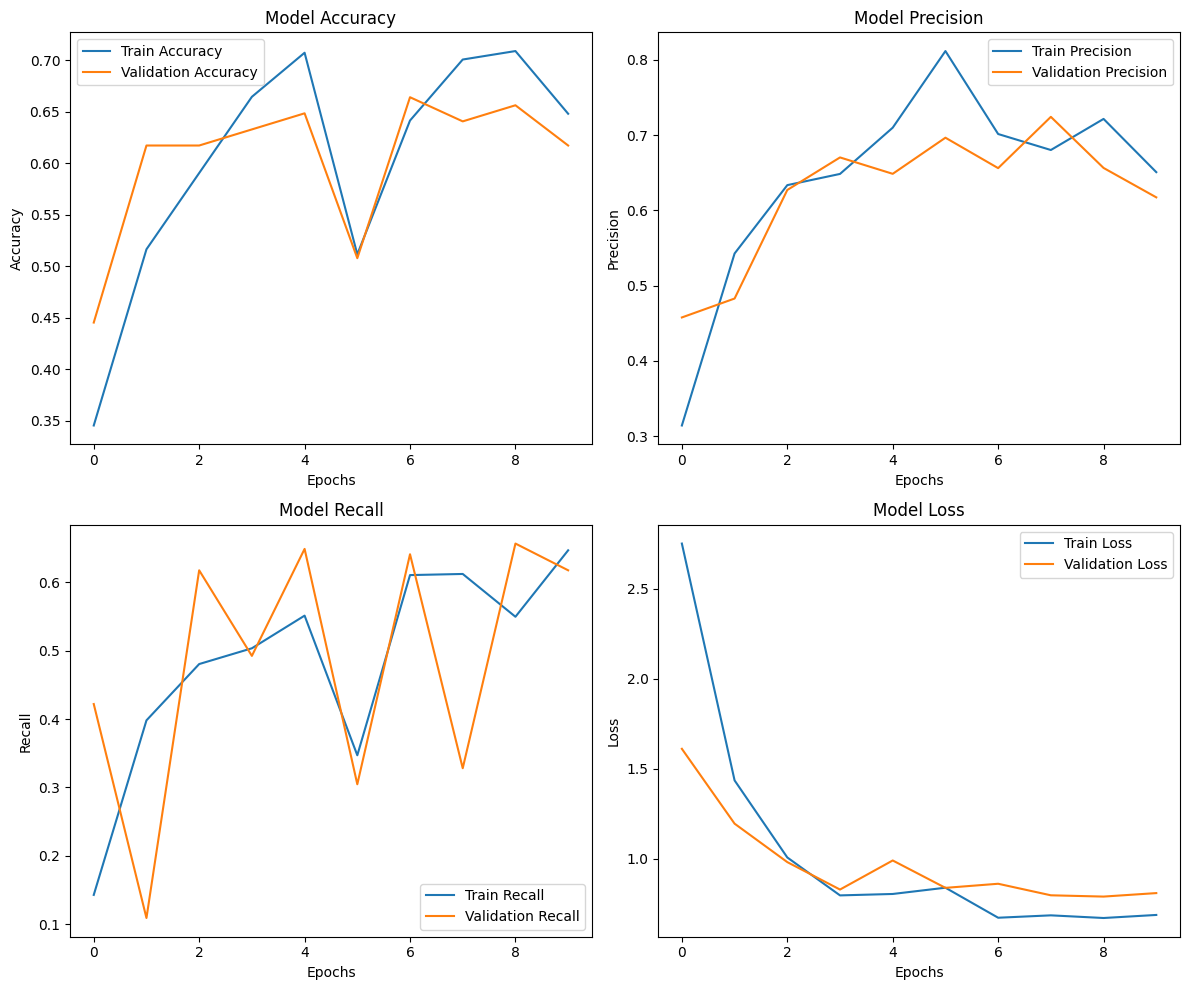

In [9]:
import matplotlib.pyplot as plt

# Extract metrics from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history['precision']  # Use lowercase
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots
plt.figure(figsize=(12, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(precision, label='Train Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(recall, label='Train Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 4)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import pandas as pd

# Path to the test directory
test_dir = "D:/VIT/Capstone/plant_dataset_main/test"  # Update with actual test dataset path

# Load plant-disease mapping from CSV
mapping_df = pd.read_csv("plant_diseases_names.csv")  # Ensure this file exists
class_mapping = {row["Folder Name"]: (row["Plant"], row["Disease"]) for _, row in mapping_df.iterrows()}

# Target image size for preprocessing (same as training)
target_size = (150, 150)  

# Iterate over each image in the test directory
for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)

    # Check if it's a valid image file
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load and preprocess the image
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions)  # Get the highest probability class

        # Get class labels from the generator
        class_labels = list(class_mapping.keys())  # List of folder names in order of training
        predicted_class_name = class_labels[predicted_class_idx]

        # Extract plant and disease information
        plant_name, disease_name = class_mapping.get(predicted_class_name, ("Unknown", "Unknown"))

        # Print the results
        print(f"Image: {img_file}, Plant: {plant_name}, Disease: {disease_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Image: 'Cercospora_capsici.jpg, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Image: AppleCedarRust1.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image: AppleCedarRust2.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: AppleCedarRust3.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: AppleCedarRust4.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image: AppleScab1.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: AppleScab2.JPG, Plant: Corn (maize), Disease: Northern Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: AppleScab3.JPG, Plant: Corn (maize), Disease: Cercospora leaf spot or Gray leaf spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: CornCommonR